In [1]:
from scipy.stats import beta
import numpy as np
from online_cp import PluginMartingale
import matplotlib.pyplot as plt

# Can we have a mixture that weights the individual martingales according to their value (before a new bet)? I think so.

In [2]:
window_size = None#500
C = 1
M1 = PluginMartingale(warnings=False, window_size=window_size)
M2 = PluginMartingale(warnings=False, kernel='beta', window_size=window_size, C=C)
M3 = PluginMartingale(warnings=False, method='beta', beta_method='moment')
M4 = PluginMartingale(warnings=False, method='beta', beta_method='mle')

In [3]:
np.random.seed(2025)
a = 1
b = 5
data = np.random.beta(a=a, b=b, size=500)
# data = np.load('../data/data_martingale_experiment/p_values_satelite_orig.npy')
# data = np.load('../data/data_martingale_experiment/p_values_usps_orig.npy')

In [4]:
logLoss_Gauss = 0
for i, p in enumerate(data):
    logLoss_Gauss += -np.log(M1.b_n(p))
    M1.update_martingale_value(p)

In [5]:
logLoss_Beta = 0
for i, p in enumerate(data):    
    logLoss_Beta += -np.log(M2.b_n(p))
    M2.update_martingale_value(p)

In [6]:
# logLoss_Moment = 0
# for i, p in enumerate(data):
#     logLoss_Moment += -np.log(M3.b_n(p))
#     M3.update_martingale_value(p)

In [7]:
# logLoss_MLE = 0
# for i, p in enumerate(data):
#     logLoss_MLE += -np.log(M4.b_n(p))
#     M4.update_martingale_value(p)

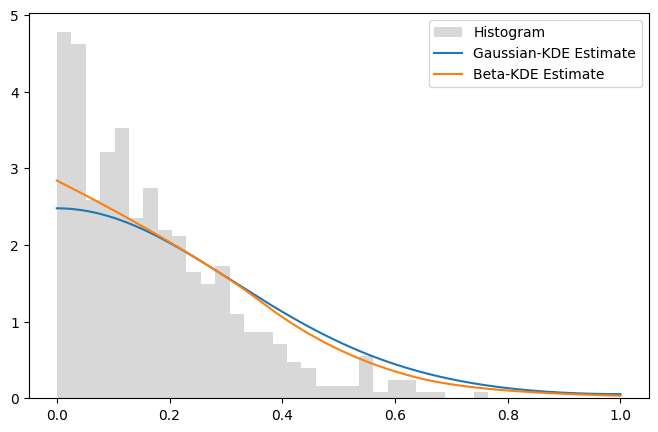

In [8]:
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label="Histogram")
plt.plot(x, M1.b_n(x), label="Gaussian-KDE Estimate")
plt.plot(x, M2.b_n(x), label="Beta-KDE Estimate")
# plt.plot(x, M3.b_n(x), label="Parametric beta (moment)")
# plt.plot(x, M4.b_n(x), label="Parametric beta (MLE)")

# plt.plot(x, beta.pdf(x, a=a, b=b), color='green', label="Truth", lw=2)
plt.legend()

In [9]:
np.exp(M1.logM), np.exp(M2.logM), np.exp(M3.logM), np.exp(M4.logM)

(np.float64(1.1221441979319326e+119),
 np.float64(4.655555611108432e+115),
 np.float64(1.0),
 np.float64(1.0))

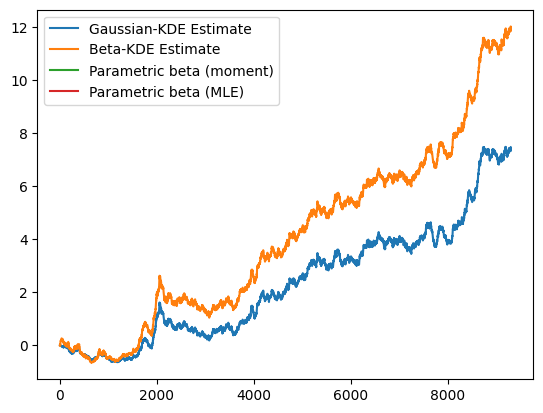

In [33]:
plt.plot(M1.log10_martingale_values, label="Gaussian-KDE Estimate")
plt.plot(M2.log10_martingale_values, label="Beta-KDE Estimate")
plt.plot(M3.log10_martingale_values, label="Parametric beta (moment)")
plt.plot(M4.log10_martingale_values, label="Parametric beta (MLE)")
plt.legend()

In [27]:
logLoss_Gauss, logLoss_Beta#, logLoss_Moment, logLoss_MLE

(np.float64(-16.984954391099404), np.float64(-27.31698919137272))

The Gaussian kernel plugin seems suspiciosly bad here. Let's compare it to the sklearn implementation

In [28]:
# Fit an sklearn Gaussan KDE to the data and compare with mine.

from sklearn.neighbors import KernelDensity
from scipy.integrate import quad

def get_density_estimate(p_values):
    P = np.array([[-p, p, 2-p] for p in p_values]).flatten()[:, np.newaxis]
    if len(P) == 0:
        return None
    kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(P)
    return kde

def f(p, d):
    if not d: 
        return 1
    if 0 <= p <= 1:
        func = lambda p :np.exp(d.score_samples([[p]])[0])
        norm_fac = quad(func, 0, 1)
        return np.exp(d.score_samples([[p]])[0]) / norm_fac[0]
    else:
        return 0.0
    
d = get_density_estimate(data)
KDE = lambda x: f(x, d)

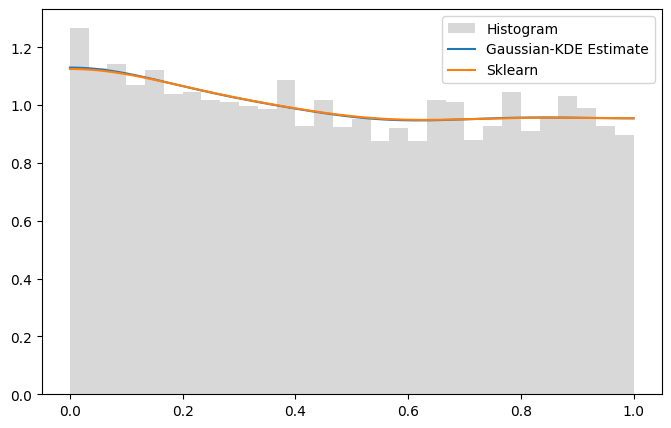

In [29]:
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label="Histogram")
plt.plot(x, M1.b_n(x), label="Gaussian-KDE Estimate")
plt.plot(x, [KDE(xi) for xi in x], label='Sklearn')
plt.legend()

In [30]:
P = data[:25]

In [31]:
P.std(), np.array([P, 2-P, -P]).flatten().std()

(np.float64(0.30250221257824184), np.float64(0.8709897160756079))